##### Haar Cascades

Phát hiện 1 khuôn mặt


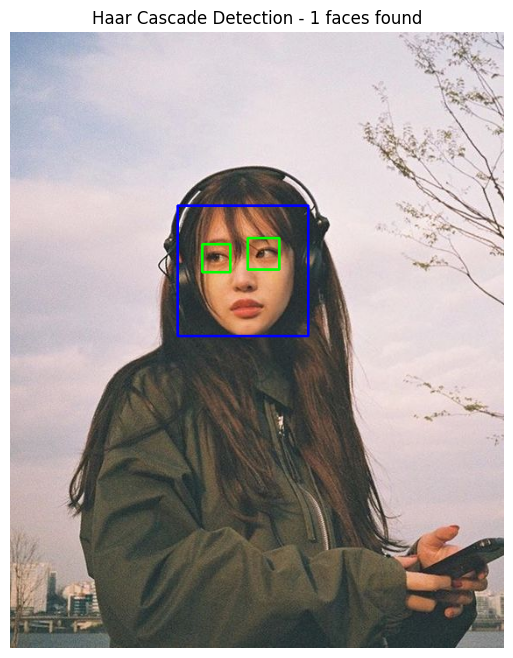

In [3]:
import cv2
import matplotlib.pyplot as plt

img_bgr = cv2.imread('face.jpg')
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

# Tải pre-trained Haar cascades
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

# Phát hiện khuôn mặt
faces = face_cascade.detectMultiScale(
    gray,
    scaleFactor=1.1,        # Hệ số scale
    minNeighbors=5,         # Số láng giềng tối thiểu
    minSize=(30, 30),       # Kích thước tối thiểu
    flags=cv2.CASCADE_SCALE_IMAGE
)

# Vẽ rectangle xung quanh khuôn mặt và phát hiện mắt
img_faces = img_bgr.copy()
for (x, y, w, h) in faces:
    cv2.rectangle(img_faces, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Phát hiện mắt trong vùng khuôn mặt
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img_faces[y:y+h, x:x+w]

    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)

print(f"Phát hiện {len(faces)} khuôn mặt")

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img_faces, cv2.COLOR_BGR2RGB))
plt.title(f'Haar Cascade Detection - {len(faces)} faces found')
plt.axis('off')
plt.show()

##### HOG (Histogram of Oriented Gradients)

In [5]:
# Tạo HOG descriptor
hog = cv2.HOGDescriptor()

# Sử dụng default people detector
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# Phát hiện người trong ảnh
boxes, weights = hog.detectMultiScale(
    gray,
    winStride=(8, 8),       # Bước trượt window
    padding=(32, 32),       # Padding xung quanh
    scale=1.05,             # Hệ số scale
    finalThreshold=2        # Threshold cuối cùng
)

# Vẽ bounding boxes
img_hog = img_bgr.copy()
for (x, y, w, h) in boxes:
    cv2.rectangle(img_hog, (x, y), (x+w, y+h), (0, 255, 0), 2)

print(f"HOG phát hiện {len(boxes)} người")

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img_hog, cv2.COLOR_BGR2RGB))
plt.title(f'HOG People Detection - {len(boxes)} people found')
plt.axis('off')
plt.show()

# Tính toán HOG features cho toàn bộ ảnh
hog_features = hog.compute(gray)
print(f"Kích thước HOG features: {hog_features.shape}")

error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'detectMultiScale'
> Overload resolution failed:
>  - 'finalThreshold' is an invalid keyword argument for HOGDescriptor.detectMultiScale()
>  - 'finalThreshold' is an invalid keyword argument for HOGDescriptor.detectMultiScale()


Kích thước ảnh gốc: (919, 736, 3)


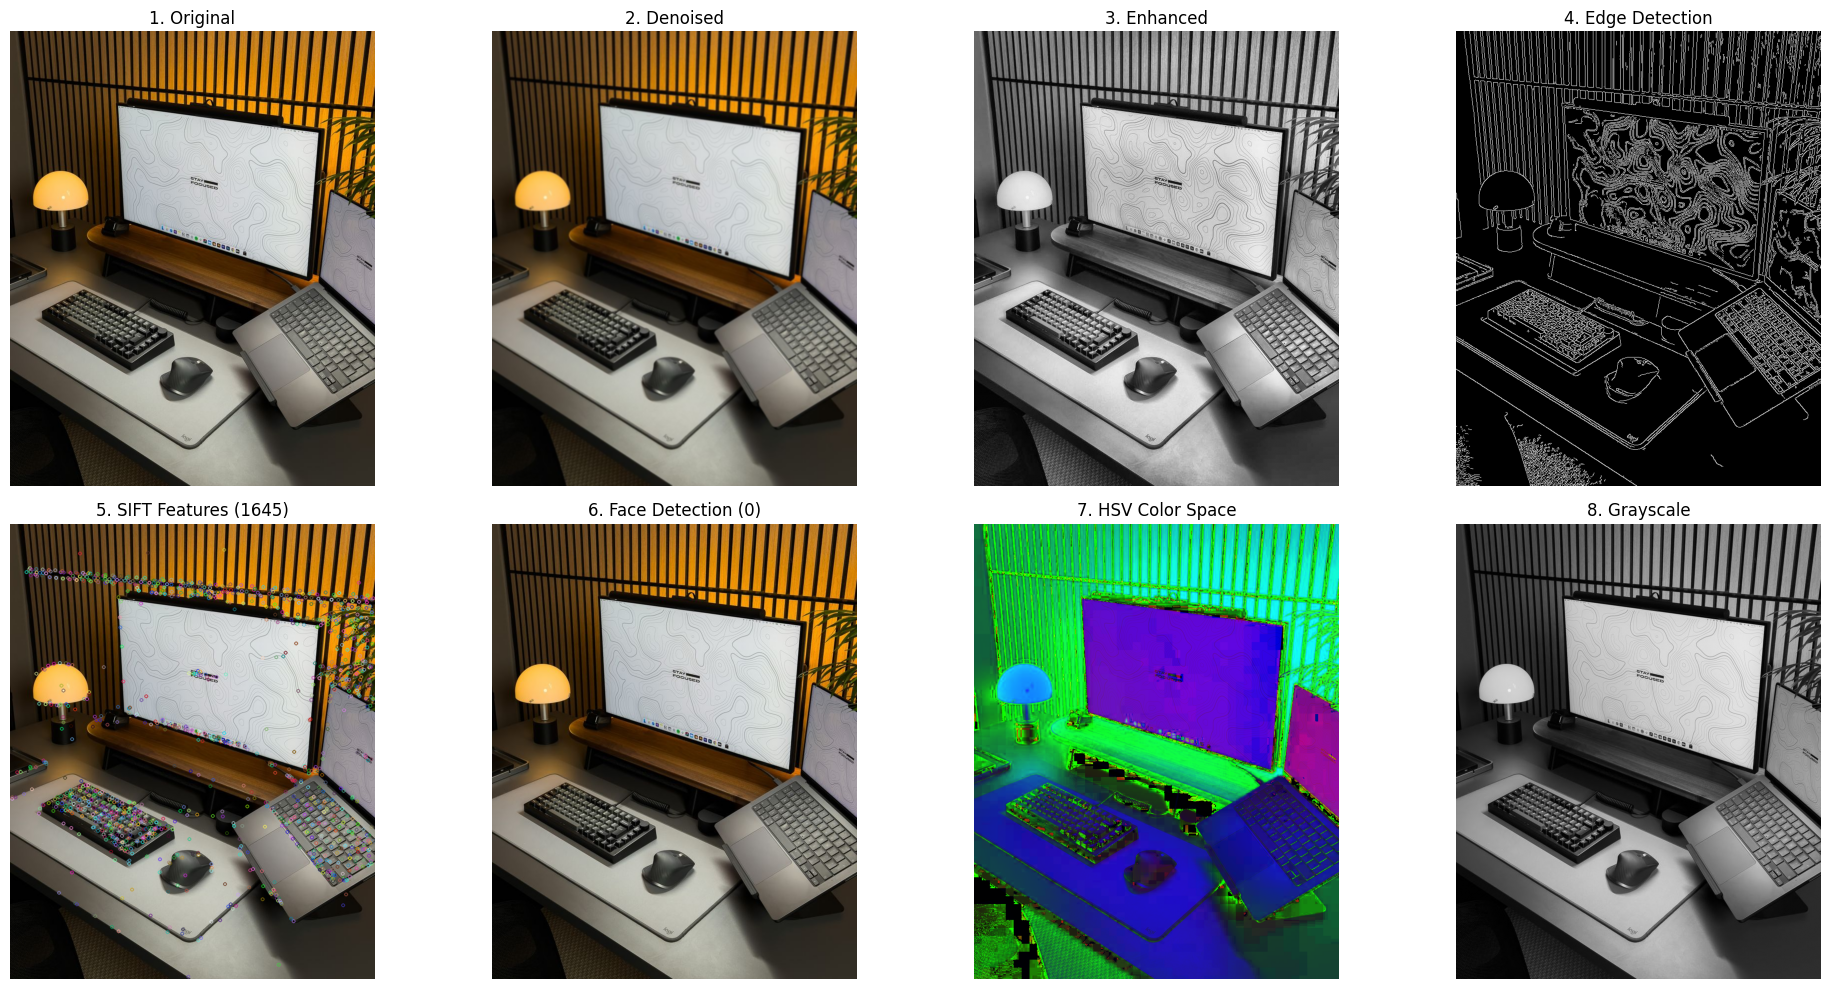

In [7]:
def image_preprocessing_pipeline(image_path):
    """
    Pipeline tổng hợp các bước tiền xử lý ảnh
    """
    # 1. Đọc ảnh
    img = cv2.imread(image_path)
    if img is None:
        print("Không thể đọc ảnh!")
        return None

    print(f"Kích thước ảnh gốc: {img.shape}")

    # 2. Chuyển đổi màu sắc
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 3. Giảm nhiễu
    denoised = cv2.GaussianBlur(img_rgb, (5, 5), 0)

    # 4. Cân bằng histogram
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(img_gray)

    # 5. Phát hiện cạnh
    edges = cv2.Canny(enhanced, 100, 200)

    # 6. Phát hiện đặc trưng
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img_gray, None)

    # 7. Phát hiện đối tượng (khuôn mặt)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(img_gray, 1.1, 4)

    # Hiển thị kết quả
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    axes[0,0].imshow(img_rgb)
    axes[0,0].set_title('1. Original')

    axes[0,1].imshow(denoised)
    axes[0,1].set_title('2. Denoised')

    axes[0,2].imshow(enhanced, cmap='gray')
    axes[0,2].set_title('3. Enhanced')

    axes[0,3].imshow(edges, cmap='gray')
    axes[0,3].set_title('4. Edge Detection')

    # Vẽ keypoints
    img_keypoints = cv2.drawKeypoints(img, keypoints, None)
    axes[1,0].imshow(cv2.cvtColor(img_keypoints, cv2.COLOR_BGR2RGB))
    axes[1,0].set_title(f'5. SIFT Features ({len(keypoints)})')

    # Vẽ faces
    img_faces = img_rgb.copy()
    for (x, y, w, h) in faces:
        cv2.rectangle(img_faces, (x, y), (x+w, y+h), (255, 0, 0), 2)
    axes[1,1].imshow(img_faces)
    axes[1,1].set_title(f'6. Face Detection ({len(faces)})')

    axes[1,2].imshow(img_hsv)
    axes[1,2].set_title('7. HSV Color Space')

    axes[1,3].imshow(img_gray, cmap='gray')
    axes[1,3].set_title('8. Grayscale')

    for ax in axes.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    return {
        'original': img_rgb,
        'denoised': denoised,
        'enhanced': enhanced,
        'edges': edges,
        'keypoints': keypoints,
        'descriptors': descriptors,
        'faces': faces
    }

# Sử dụng pipeline
results = image_preprocessing_pipeline('image.jpg')